In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
data_path = "BRATS/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/"

In [5]:
subject_dirs = sorted(glob(os.path.join(data_path, '*')))
example_subject = subject_dirs[0]
print("Using subject:", example_subject)

Using subject: BRATS/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000


In [6]:
def load_nifti(filepath):
    return nib.load(filepath).get_fdata()

In [7]:
example_subject

'BRATS/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000'

In [8]:
def get_modalities(subject_folder):
    modalities = {}
    files = os.listdir(subject_folder)
    
    for file in files:
        if not file.endswith('.nii.gz'):
            continue
        lower_file = file.lower()
        if lower_file.endswith('-t1n.nii.gz'):
            modalities['T1n'] = load_nifti(os.path.join(subject_folder, file))
        elif lower_file.endswith('-t1c.nii.gz'):
            modalities['T1c'] = load_nifti(os.path.join(subject_folder, file))
        elif lower_file.endswith('-t2w.nii.gz'):
            modalities['T2w'] = load_nifti(os.path.join(subject_folder, file))
        elif lower_file.endswith('-t2f.nii.gz'):
            modalities['T2f'] = load_nifti(os.path.join(subject_folder, file))
        elif lower_file.endswith('-seg.nii.gz'):
            modalities['Seg'] = load_nifti(os.path.join(subject_folder, file))
    
    # Optionally check if any modality is missing:
    required = ['T1n', 'T1c', 'T2w', 'T2f', 'Seg']
    for mod in required:
        if mod not in modalities:
            print(f"Warning: {mod} modality missing in {subject_folder}")
    
    return modalities

In [31]:
def plot_modalities(mods, slice_idx):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, (key, vol) in enumerate(mods.items()):
        axes[i].imshow(vol[:, :, slice_idx], cmap='gray' if key != 'Seg' else 'jet')
        axes[i].set_title(key)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

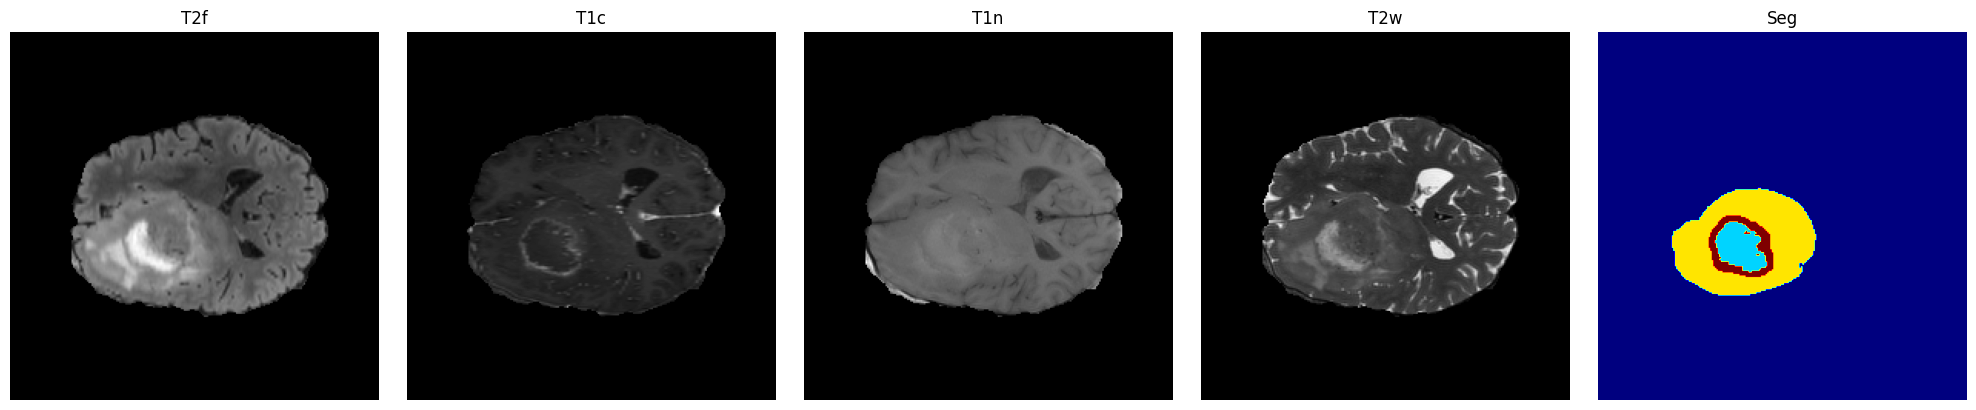

In [39]:
example_subject = subject_dirs[1]
modalities = get_modalities(example_subject)
plot_modalities(modalities, slice_idx=80)

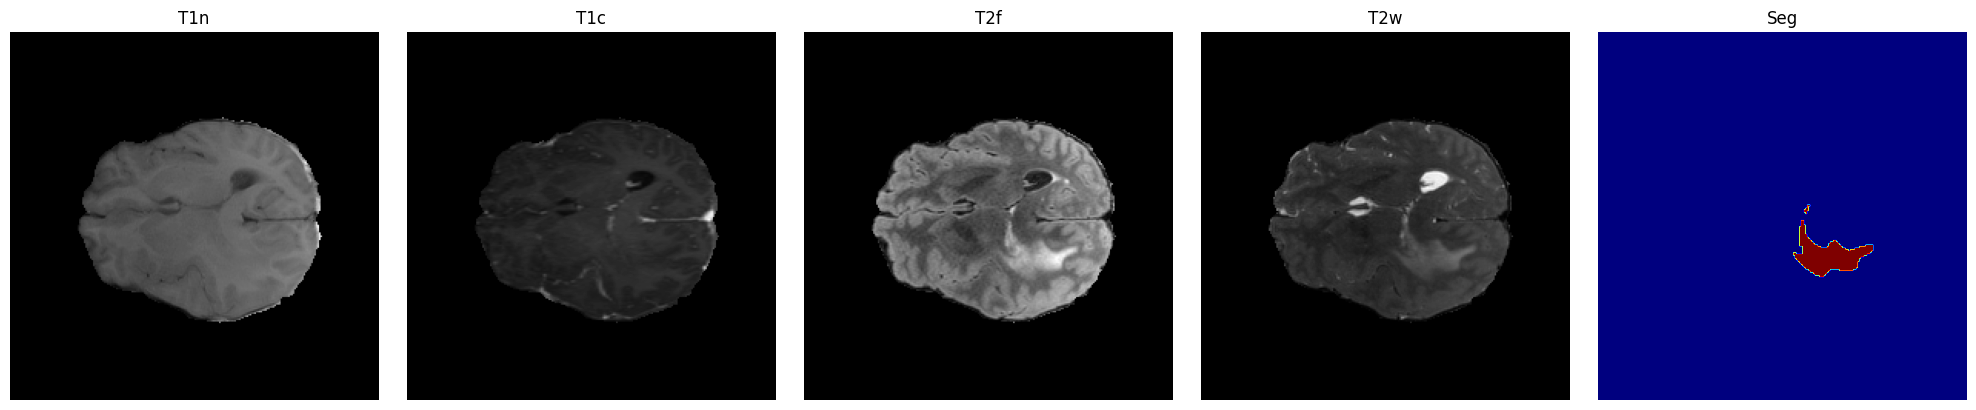

In [40]:
example_subject = subject_dirs[3]
modalities = get_modalities(example_subject)
plot_modalities(modalities, slice_idx=80)

In [12]:
def normalize(volume):
    mean = np.mean(volume)
    std = np.std(volume)
    return (volume - mean) / std

In [13]:
for key in ['T1n', 'T1c', 'T2w', 'T2f']:
    modalities[key] = normalize(modalities[key])

In [14]:
image = np.stack([modalities['T1n'], modalities['T1c'], modalities['T2w'], modalities['T2f']], axis=0)
seg = modalities['Seg']
print("Input shape:", image.shape)

Input shape: (4, 240, 240, 155)


In [15]:
def extract_random_patch(image, label, patch_size=(128, 128, 64)):
    c, h, w, d = image.shape
    ph, pw, pd = patch_size
    h_start = np.random.randint(0, h - ph)
    w_start = np.random.randint(0, w - pw)
    d_start = np.random.randint(0, d - pd)

    image_patch = image[:, h_start:h_start+ph, w_start:w_start+pw, d_start:d_start+pd]
    label_patch = label[h_start:h_start+ph, w_start:w_start+pw, d_start:d_start+pd]
    return image_patch, label_patch

In [16]:
img_patch, seg_patch = extract_random_patch(image, seg)
print("Patch shape:", img_patch.shape, seg_patch.shape)

Patch shape: (4, 128, 128, 64) (128, 128, 64)


In [17]:
def dice_score(pred, truth, label):
    pred_bin = (pred == label)
    truth_bin = (truth == label)
    intersection = np.sum(pred_bin & truth_bin)
    return (2. * intersection) / (np.sum(pred_bin) + np.sum(truth_bin) + 1e-6)

In [18]:
pred_dummy = seg_patch.copy()  

In [19]:

print("Dice (ET=3):", dice_score(pred_dummy, seg_patch, label=3))

# --- 8. CONCLUSION ---
print("\nThis notebook demonstrated loading, preprocessing, and patch preparation for BraTS 2023 brain tumor data.")
print("Next steps could include training a 3D U-Net model on patches or exploring visualization in 3D.")


Dice (ET=3): 0.9999999954128441

This notebook demonstrated loading, preprocessing, and patch preparation for BraTS 2023 brain tumor data.
Next steps could include training a 3D U-Net model on patches or exploring visualization in 3D.


In [20]:
# --- 7. SIMPLE 3D U-NET ---
class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, init_features=16):
        super(UNet3D, self).__init__()
        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.bottleneck = self._block(features * 2, features * 4)

        self.upconv2 = nn.ConvTranspose3d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block((features * 2) * 2, features * 2)
        self.upconv1 = nn.ConvTranspose3d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features)

        self.conv = nn.Conv3d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        bottleneck = self.bottleneck(self.pool2(enc2))

        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))
        return self.conv(dec1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )


In [21]:
class BraTSDataset(Dataset):
    def __init__(self, subject_dirs, patch_size=(128, 128, 64), num_patches=5):
        self.subject_dirs = subject_dirs
        self.patch_size = patch_size
        self.num_patches = num_patches

    def __len__(self):
        return len(self.subject_dirs) * self.num_patches

    def __getitem__(self, idx):
        subject_folder = self.subject_dirs[idx // self.num_patches]
        
        # Use the dynamic loader here:
        modalities = get_modalities(subject_folder)
        
        # Normalize each modality except 'Seg' (already loaded normalized if needed)
        for key in ['T1n', 'T1c', 'T2w', 'T2f']:
            modalities[key] = normalize(modalities[key])
        
        # Stack into input tensor
        img = np.stack([modalities['T1n'], modalities['T1c'], modalities['T2w'], modalities['T2f']], axis=0)
        label = modalities['Seg']

        # Extract patch
        img_patch, label_patch = extract_random_patch(img, label, self.patch_size)

        return torch.tensor(img_patch).float(), torch.tensor(label_patch).long()


In [ ]:
dataset = BraTSDataset(subject_dirs[:5]) # Dde to limited resources I carried out experiment on a small subset of data only
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [24]:
model = UNet3D()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [25]:
model.train()
for epoch in range(15):
    total_loss = 0
    for batch in dataloader:
        x, y = batch
        y = y.unsqueeze(1)  # (B, 1, H, W, D)
        logits = model(x)
        loss = criterion(logits, y.squeeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(dataloader):.4f}")


Epoch 1: Loss = 0.6570
Epoch 2: Loss = 0.1833
Epoch 3: Loss = 0.1634
Epoch 4: Loss = 0.1566
Epoch 5: Loss = 0.2131
Epoch 6: Loss = 0.1257
Epoch 7: Loss = 0.1788
Epoch 8: Loss = 0.1216
Epoch 9: Loss = 0.1424
Epoch 10: Loss = 0.1220
Epoch 11: Loss = 0.1779
Epoch 12: Loss = 0.1151
Epoch 13: Loss = 0.1554
Epoch 14: Loss = 0.1249
Epoch 15: Loss = 0.1077


In [27]:
# inference
model.eval()
x, y = next(iter(dataloader))
with torch.no_grad():
    out = model(x)
    pred = torch.argmax(out, dim=1).squeeze(0).numpy()
    gt = y.squeeze(0).numpy()
    print("Dice (ET=3):", dice_score(pred, gt, label=3))

Dice (ET=3): 0.0


The higher the dice score, the better the model, dice score 0 means there is no overlap between predicted and true Enhancing Tumor regions. This likely happened because the model was trained on a very small subset of the data, it has not yet learned to accurately identify this tumor subtype.
